# Using XyloSamna and XyloMonitor to deploy a model on XyloAudio 3 HDK

## Common steps for both Accelerated and Real-time mode

### Loading the trained model

In this example, we use a trained model for a multiclass classification task: detecting rare sounds like glass-break, gun-shot, scream, and background noise. The model was trained using the Mivia Audio Events Dataset: https://mivia.unisa.it/datasets/audio-analysis/mivia-audio-events/. The model is composed of 16 input channels, three layers of Leaky Integrate-and-Fire (LIF) neurons, and four output neurons, one for each class.  

In [1]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch
import warnings
warnings.filterwarnings("ignore")

ckpt = 'model_sample/to_deploy_inXylo.json'

#  trained model architecture parameters
arch_params = {'n_classes': 4,
'n_channels': 16,
'size_hidden_layers':[63, 63, 63],
'time_constants_per_layer':[3,7,7],
'tau_syn_base': 0.02,
'tau_mem': 0.02,
'tau_syn_out': 0.02,
'neuron_model': LIFTorch,
'dt': 0.00994,
'output': 'vmem'}

# Number of input channels
Nin = 16
model_dt = 0.009994

# instantiating the model backbone and loading trained checkpoint
model = SynNet(** arch_params)
model.load(ckpt)

Looking in indexes: https://gitlab.com/api/v4/projects/27423070/packages/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 MB 4.6 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: samna
    Found existing installation: samna 0.48.0
    Uninstalling samna-0.48.0:
      Successfully uninstalled samna-0.48.0



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]
WARNING    /home/vleite/SynSense/rockpool/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
 [py.warnings]


### Mapping, quantizing and building the configuration object for XyloAudio 3 HDK 

In [2]:
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper
import rockpool.transform.quantize_methods as q

# getting the model specifications using the mapper function
spec = mapper(model.as_graph(), weight_dtype='float', threshold_dtype='float', dash_dtype='float')
# quantizing the model
spec.update(q.channel_quantize(**spec))

xylo_conf, is_valid, msg = config_from_specification(**spec)

## Using XyloSamna in Accelerated time mode
In *Accelerated time* mode we can give a specific input to XyloAudio that will be processed as quickly as possible, while allowing the monitoring of the internal network state.
This mode is ideal for benchmarking and validating models.

In *Accelerated time*, the input has to be a list of spike events ordered by timestep. 

### Creating XyloSamna: API to interact with HDK in *Accelerated time* mode

**Note: We need an AudioXylo 3 connected to run this step**

In [3]:
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdu
from rockpool.devices.xylo.syns65302 import XyloSamna
import samna

# Getting the connected devices and choosing XyloAudio 3 board
xylo_nodes = hdu.find_xylo_a3_boards()

if len(xylo_nodes) == 0:
    raise ValueError('A connected XyloAudio 3 development board is required for this tutorial.')

xa3 = xylo_nodes[0]

# Instantiating XyloSamna and deploying to the dev kit; make sure your dt corresponds to the dt of your input data
Xmod = XyloSamna(device=xa3, config=xylo_conf, dt = model_dt)

### Feeding test samples of rare-sounds to XyloSamna and analyzing recorded states
- Please see [this tutorial](AFESim3_as_transform.ipynb) as an example on how to convert audio signals into spike trains.

Testing glass sound
Detected sound: glass 



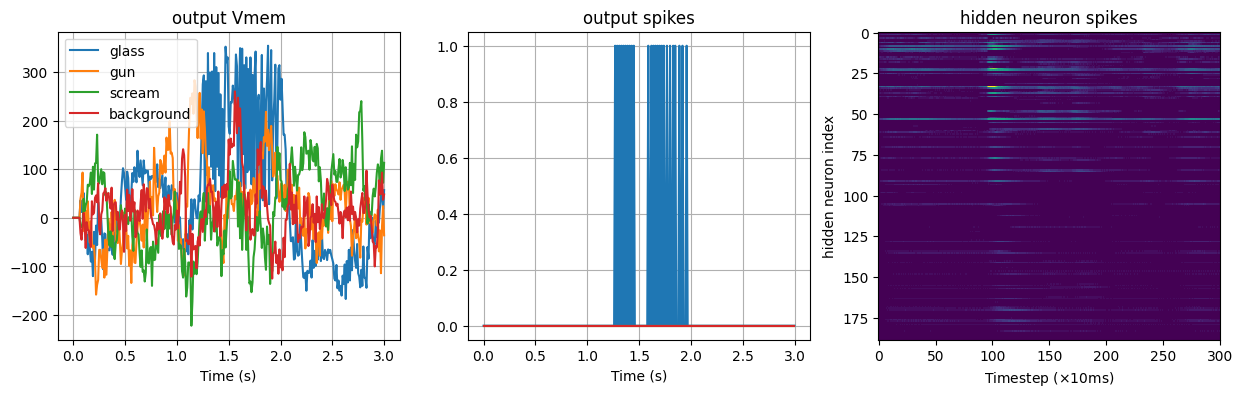

Testing gun sound
Detected sound: gun 



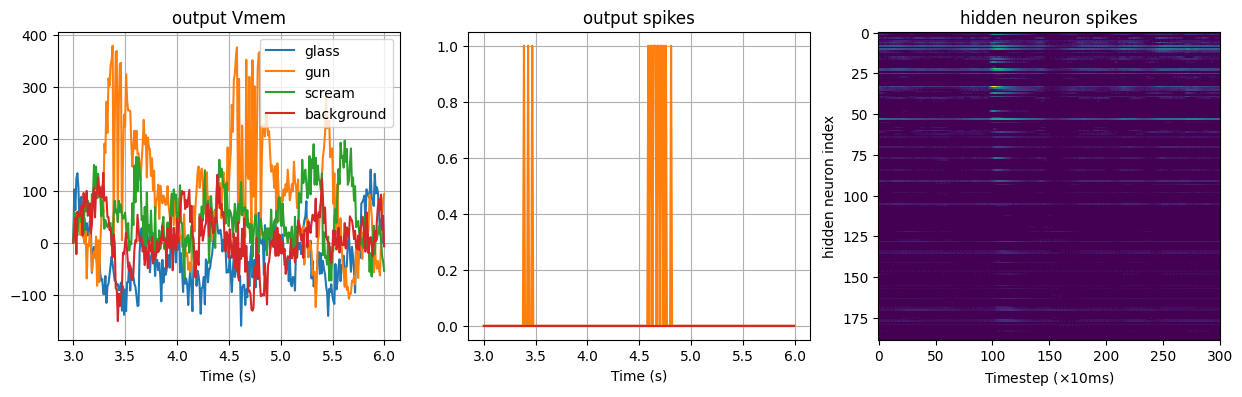

Testing scream sound
Detected sound: scream 



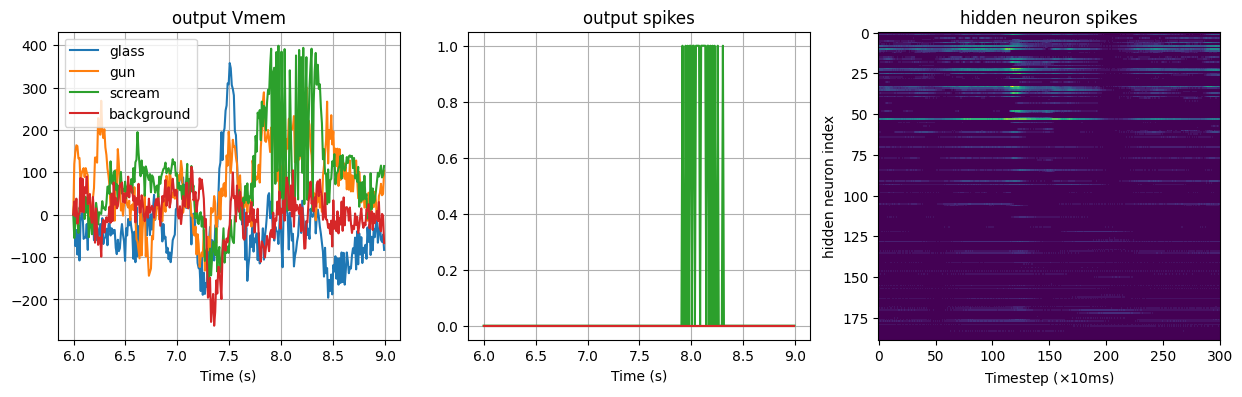

Testing background sound
Detected sound: background 



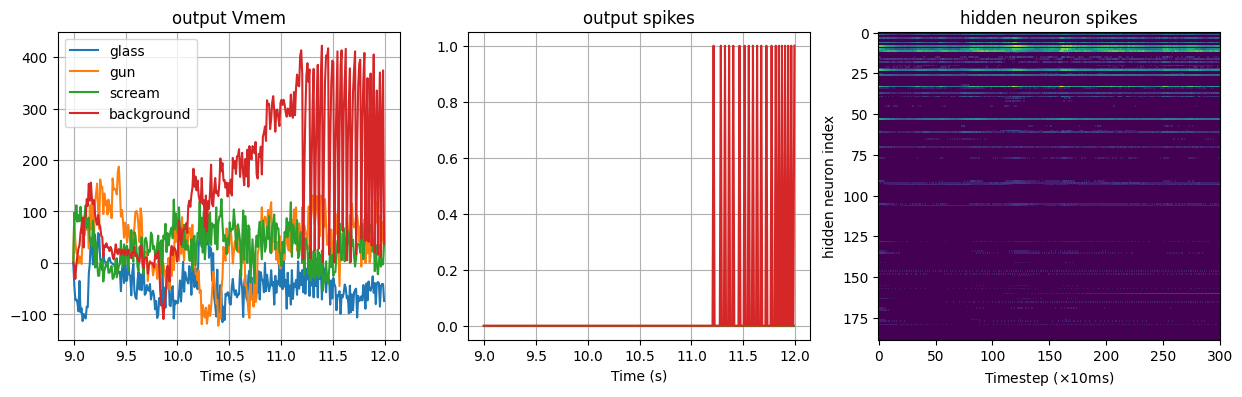

In [4]:
import numpy as np
import matplotlib.pyplot as plt

rare_sounds = ['glass', 'gun', 'scream', 'background']

for sound in rare_sounds:
    print(f'Testing {sound} sound') 
    test_sample = np.load(f'afesim_sample/AFESimExternalSample_{sound}.npy', allow_pickle=True)
    # with XyloSamna we can record the internal state of the network
    out, _, rec = Xmod(test_sample, record=True)
    prediction = rare_sounds[np.argmax(np.sum(out, axis = 0))]
    print(f'Detected sound: {prediction} \n') 

    # Show internal states 
    plt.figure(figsize=(15,4))
    plt.subplot(131); plt.plot(rec['times'], rec['Vmem_out'], label = rare_sounds);plt.legend(), plt.grid(True); plt.xlabel('Time (s)'); plt.title('output Vmem'); 
    plt.subplot(132); plt.plot(rec['times'], out);plt.grid(True); plt.xlabel('Time (s)'); plt.title('output spikes'); 
    plt.subplot(133); plt.imshow(rec['Spikes'].T, aspect='auto', interpolation='none'); plt.xlabel('Timestep ($\\times$10ms)'); plt.ylabel('hidden neuron index'); plt.title('hidden neuron spikes');
    plt.show()
    


## Using XyloMonitor in Real Time mode
In *Real-time* mode, XyloAudio 3 continuously processes events as they are received.
Events are received directly from one of the onboard microphones instead of event-based input.

In this mode, the chip operates autonomously, collecting inputs and processing them. Once the processing is done, XyloAudio 3 outputs all generated spike events. It is not possible to interact with the chip during this period. Thus, the collection of internal neuron states is not permitted.

### Creating XyloMonitor: API to interact with HDK in *Real-time* mode

In [5]:
import samna
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdu
from rockpool.devices.xylo.syns65302 import XyloMonitor

          

In [6]:
from scipy.io import wavfile
!pip install simpleaudio
import simpleaudio as sa
import numpy as np

def get_wave_object(test_file): 
    sample_rate, data = wavfile.read(test_file)
  
    duration = int(len(data)/sample_rate) # in seconds
    n = data.ndim

    if data.dtype == np.int8:
        bytes_per_sample = 1
    elif data.dtype == np.int16:
        bytes_per_sample = 2
    elif data.dtype == np.float32:
        bytes_per_sample = 4   
    else:
        raise ValueError("recorded audio should have 1 or 2 bytes per sample!")

    wave_obj = sa.WaveObject(
        audio_data= data,
        num_channels=data.ndim,
        bytes_per_sample=bytes_per_sample,
        sample_rate=sample_rate
    )  

    return duration,wave_obj   

  Using cached simpleaudio-1.0.4.tar.gz (2.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-linux_x86_64.whl size=2054760 sha256=8fc2e4d805e2e5d7d01ef5dcfe8bda248645d8df370b632a73d524876c51695b
  Stored in directory: /home/vleite/.cache/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


**Warning**: The next cell will play an audio sample for each class (glass-break, gun-shot, scream, background). If you would like to test the detection using the XYloAudio development board, make sure the microphone on the board is close to your PC speaker, at a reasonable volume.

In [7]:
for sound in rare_sounds:
    print(f'Testing {sound} sound') 
    # Load audio sample
    test_audio = f'audio_sample/{sound}_sample.wav'
    duration, wave_obj = get_wave_object(test_audio)
    T = int(duration/model_dt) # timesteps

    # Instantiate XyloMonitor, deploy network to device
    xylo_monitor  = XyloMonitor(device=xa3, config=xylo_conf, dt = model_dt, output_mode='Spike', dn_active = True, main_clk_rate=12.5)
    
    # Evolve XyloMonitor object
    play_obj = wave_obj.play()
    out, state, rec = xylo_monitor.evolve(input_data=np.zeros([T, Nin]), record_power=True)
    play_obj.wait_done()

    # Prediction
    prediction = rare_sounds[np.argmax(np.sum(out, axis = 0))]
    print(f'Detected sound: {prediction} \n') 

Testing glass sound
Detected sound: glass 

Testing gun sound
Detected sound: gun 

Testing scream sound
Detected sound: scream 

Testing background sound
Detected sound: scream 



### Power consumption

In [8]:
io_power = np.mean(rec['io_power'])
analog = np.mean(rec['analog_power'])
digital = np.mean(rec['digital_power'])

print(f'XyloAudio 3\nio:\t{np.ceil(io_power * 1e6):.0f} µW\tAFE core:\t{np.ceil(analog * 1e6):.0f} µW\tDFE+SNN core:\t{np.ceil(digital * 1e6):.0f} µW\n')


XyloAudio 3
io:	456 µW	AFE core:	13 µW	DFE+SNN core:	606 µW

